### Fusion des bases de données `df_regressions` et `ee_bp19`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df1 = pd.read_csv("df_regressions.csv")
df2 = pd.read_csv("ee_bp19.csv")
df2['D'] = df2['D']/100
# Fusion des deux dataframes
df = df1.merge(df2, on="Dep")

In [3]:
df.head()

,Dep,D9/D1,Rev_median,Ndip25_34,intens_pauvr,chom19,chom24,Dem_empl15_64,tauxpauvrete,G,C,D
0,Ain,3.5,24810.0,11.5,20.4,6.050,5.600,10.3,10.8,0.247537,0.327883,0.004246
1,Aisne,3.1,20920.0,17.6,20.1,11.800,10.500,15.8,18.8,0.201414,0.237194,0.005614
2,Allier,3.0,21500.0,14.8,20.1,9.050,7.925,13.7,16.2,0.260370,0.306293,0.004333
3,Alpes-de-Haute-Provence,3.2,21790.0,12.7,20.5,10.075,7.925,16.0,17.1,0.298026,0.291808,0.004102
4,Hautes-Alpes,3.0,22010.0,9.7,19.9,7.925,6.225,15.8,14.7,0.306485,0.313522,0.003800


### Régression linéaire

In [4]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [5]:

# variables explicatives (X) et cibles (Y)
features_cols = ['D9/D1', 'Rev_median', 'Ndip25_34', 'chom19', 'Dem_empl15_64', 'tauxpauvrete']

X = df[features_cols]

# On standardise pour comparer l'importance des coefficients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features_cols)

X_final = sm.add_constant(X_scaled)

# --- RÉGRESSIONS ET AFFICHAGE COMPLET ---
partis = {'GAUCHE': 'G', 'CENTRE': 'C', 'DROITE': 'D'}

resume_significativite = pd.DataFrame(index=features_cols)

print(" ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ".center(80, "="))

for nom, col in partis.items():
    y = df[col]
    
    # Ajustement du modèle
    model = sm.OLS(y, X_final)
    
    try:
        results = model.fit(cov_type="HC1") 
        
        print(f"\n\n{'#'*30}")
        print(f" RÉSULTATS POUR : {nom} ")
        print(f"{'#'*30}")
        
        # On affiche le résumé complet
        print(results.summary())
        
        # On stocke les p-valeurs pour une vue d'ensemble à la fin
        resume_significativite[f'P-val {nom}'] = results.pvalues.drop('const')
        
    except Exception as e:
        print(f"\nErreur sur {nom} (probablement pas assez de données dans l'échantillon test) : {e}")

# --- Variables explicatives et P_valeurs ---
print("\n\n" + "="*80)
print(" RÉSUMÉ DES P-VALEURS (Seuil : 5%) ")
print("="*80)
print(resume_significativite.round(4))

======================== ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ========================


##############################
 RÉSULTATS POUR : GAUCHE 
##############################
                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     16.63
Date:                Wed, 24 Dec 2025   Prob (F-statistic):           1.24e-12
Time:                        10:55:07   Log-Likelihood:                 191.63
No. Observations:                  93   AIC:                            -369.3
Df Residuals:                      86   BIC:                            -351.5
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err    

##### Vérification modèle de régression linéaire

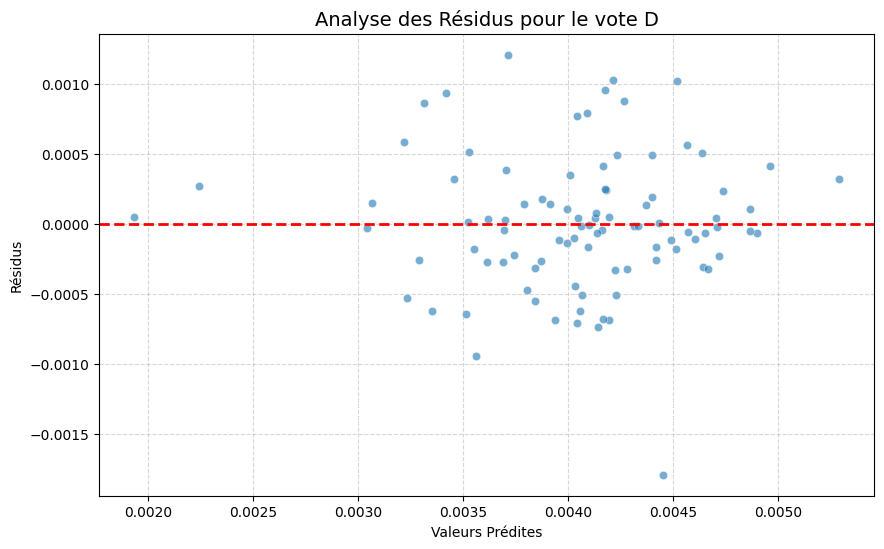

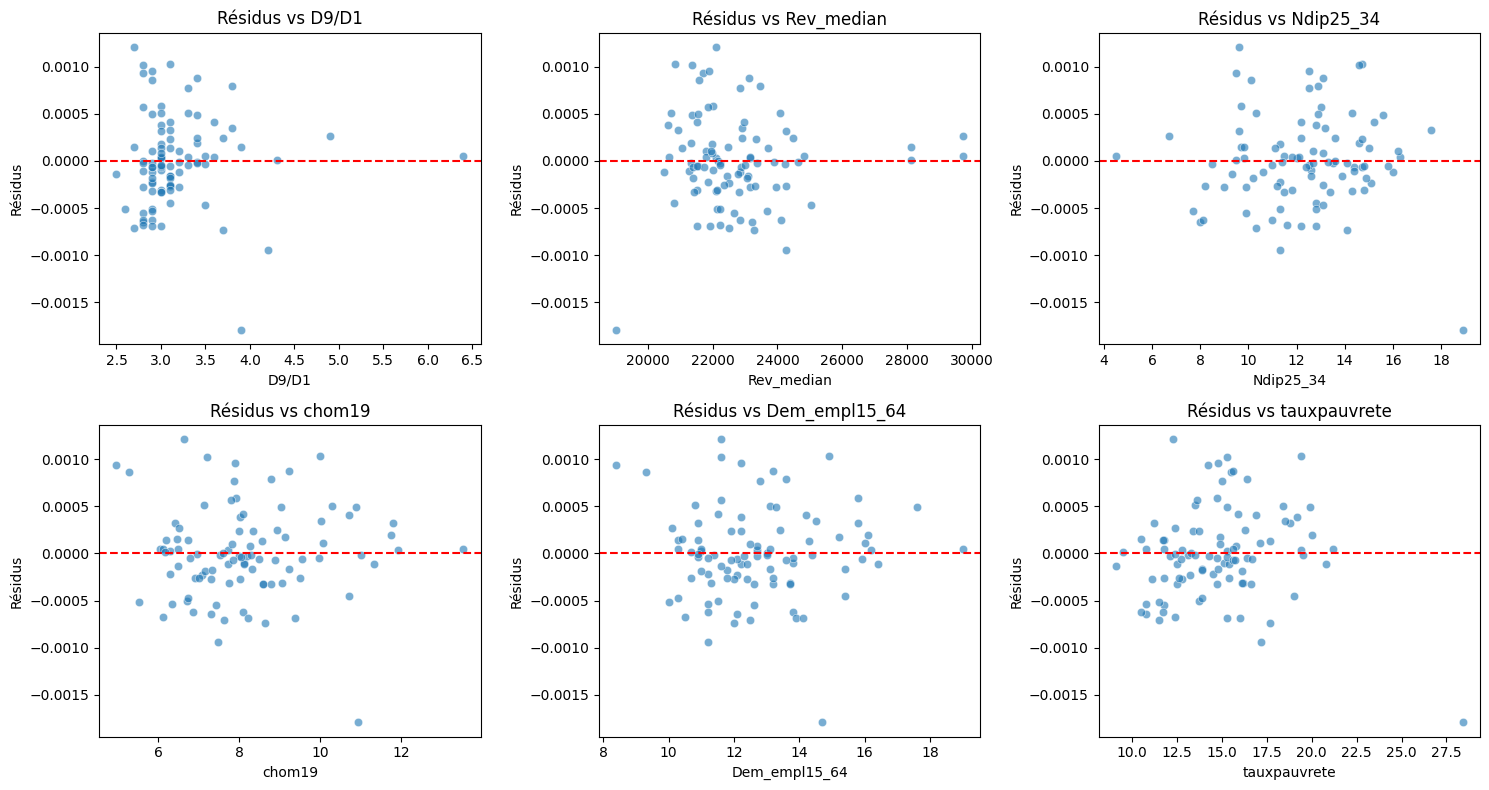

--- Corrélation entre les résidus et les variables explicatives (D) ---
D9/D1            6.987639e-16
Rev_median       4.809818e-16
Ndip25_34       -6.669181e-16
chom19          -2.470183e-16
Dem_empl15_64   -1.157380e-16
tauxpauvrete     3.366986e-17
dtype: float64


In [6]:

# Remplacer 'target_col' par G ou C pour visualiser pour les autres partis

target_col = 'D' 
y = df[target_col]

model = sm.OLS(y, X_final)
try:
    results = model.fit(cov_type='HC1')
    
    # On récupère les résidus et les prédictions
    residus = results.resid
    predictions = results.fittedvalues
    
    # ==============================================================================
    # RÉSIDUS vs VALEURS PRÉDITES 
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predictions, y=residus, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2) # Ligne zéro
    plt.title(f'Analyse des Résidus pour le vote {target_col}', fontsize=14)
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Résidus')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==============================================================================
    # RÉSIDUS vs VARIABLES EXPLICATIVES
    # ==============================================================================
    
    # On selectionne les variables principales (excluant la constante)
    vars_to_check = features_cols 
    
    # Graphique
    n_cols = 3
    n_rows = (len(vars_to_check) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() # Aplatir pour itérer facilement

    for i, col_name in enumerate(vars_to_check):
        sns.scatterplot(x=df[col_name], y=residus, ax=axes[i], alpha=0.6)
        axes[i].axhline(0, color='red', linestyle='--', lw=1.5)
        axes[i].set_title(f'Résidus vs {col_name}')
        axes[i].set_ylabel('Résidus')
        axes[i].set_xlabel(col_name)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # CORRÉLATION
    # ==============================================================================
    print(f"--- Corrélation entre les résidus et les variables explicatives ({target_col}) ---")
    correlation_check = df[features_cols].apply(lambda x: x.corr(residus))
    print(correlation_check)

except Exception as e:
    print(f"Erreur (probablement due au manque de données dans l'échantillon test) : {e}")

    On constate que les corrélations sont proches de 0.

### Résumé global de l'analyse pour 2019

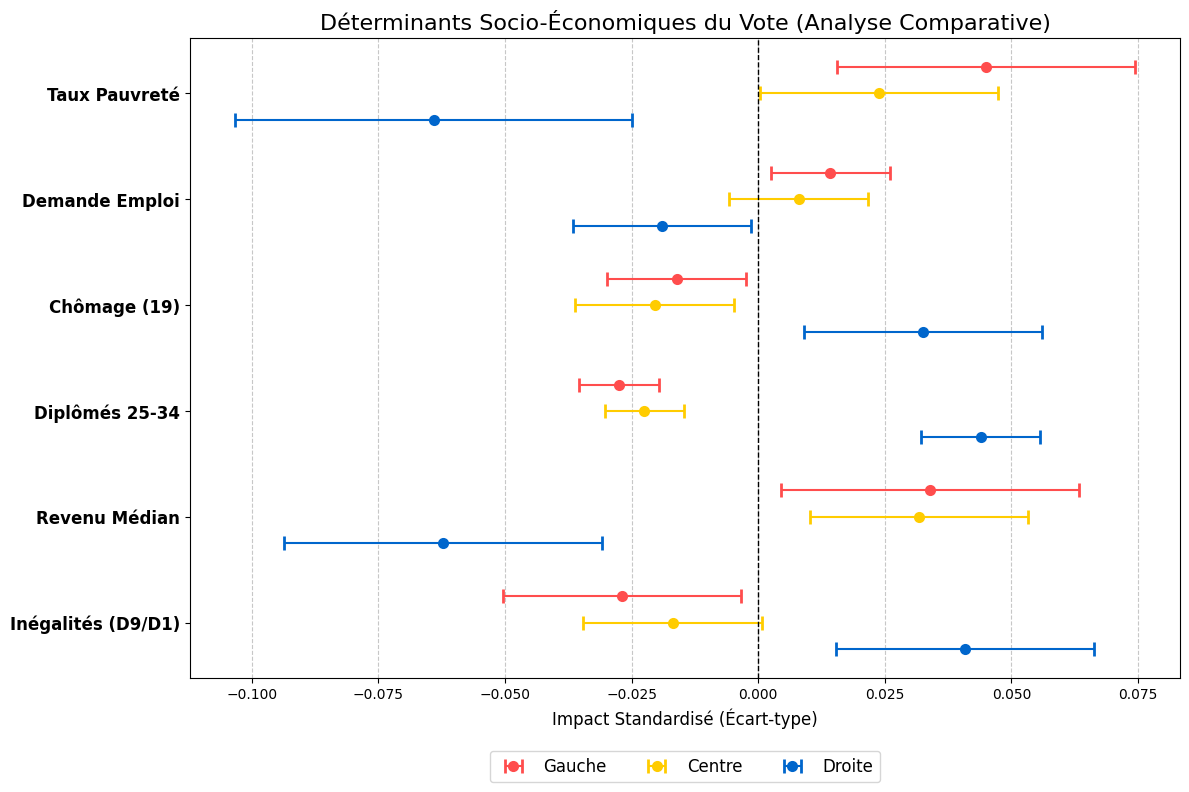

In [7]:
# On copie les valeurs exactes (Coefs et erreurs) de la régression précédente

data_viz = {
    'Variable': ['Inégalités (D9/D1)', 'Revenu Médian', 'Diplômés 25-34', 
                 'Chômage (19)', 'Demande Emploi', 'Taux Pauvreté'],
    
    # GAUCHE 
    'G_coef': [-0.0269, 0.0339, -0.0275, -0.0161, 0.0142, 0.0450],
    'G_err':  [0.012,   0.015,  0.004,   0.007,   0.006,  0.015],
    
    # CENTRE 
    'C_coef': [-0.0169, 0.0317, -0.0225, -0.0204, 0.0080, 0.0239],
    'C_err':  [0.009,   0.011,  0.004,   0.008,   0.007,  0.012],
    
    # DROITE 
    'D_coef': [0.0408, -0.0622, 0.0439, 0.0326, -0.0190, -0.0641],
    'D_err':  [0.013,   0.016,  0.006,   0.012,   0.009,   0.020]
}

df_viz = pd.DataFrame(data_viz)

# Calcul des intervalles de confiance à 95% (1.96 * StdErr)
df_viz['G_ci'] = df_viz['G_err'] * 1.96
df_viz['C_ci'] = df_viz['C_err'] * 1.96
df_viz['D_ci'] = df_viz['D_err'] * 1.96

# Graphique
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(df_viz))
height = 0.25  # Épaisseur des barres

colors = {'G': '#ff4d4d', 'C': '#ffcc00', 'D': '#0066cc'} # Rouge, Jaune, Bleu

# On visualise chaque parti

# GAUCHE
ax.errorbar(df_viz['G_coef'], y_pos + height, xerr=df_viz['G_ci'], 
            fmt='o', color=colors['G'], label='Gauche', capsize=5, markeredgewidth=2)

# CENTRE
ax.errorbar(df_viz['C_coef'], y_pos, xerr=df_viz['C_ci'], 
            fmt='o', color=colors['C'], label='Centre', capsize=5, markeredgewidth=2)

# DROITE
ax.errorbar(df_viz['D_coef'], y_pos - height, xerr=df_viz['D_ci'], 
            fmt='o', color=colors['D'], label='Droite', capsize=5, markeredgewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_viz['Variable'], fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='--', linewidth=1) # Ligne zéro
ax.set_xlabel('Impact Standardisé (Écart-type)', fontsize=12)
ax.set_title('Déterminants Socio-Économiques du Vote (Analyse Comparative)', fontsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

L'analyse des données nous montre clairement que le paysage politique français est coupé en trois, et que chaque camp correspond à une réalité économique bien précise. Ce n'est plus seulement une question d'idées : on voit que la situation financière et sociale du département joue un rôle majeur dans la façon dont les gens votent.

Le vote du Centre est sans doute le plus simple à comprendre : c'est le vote de la stabilité et de la réussite économique. Les chiffres sont très clairs là-dessus, puisque ce bloc réalise ses meilleurs scores dans les départements où le niveau de vie est élevé. À l'inverse, c'est un vote qui ne supporte pas la crise : dès que le chômage augmente, le score du Centre s'effondre. C'est donc le choix privilégié de la "France qui va bien", celle qui a intérêt à ce que le système ne change pas trop.

Pour la Droite, c'est exactement l'inverse. Ce vote se nourrit des fractures sociales. Il est particulièrement fort là où il y a du chômage et là où les inégalités de revenus sont les plus criantes. C'est clairement l'expression d'une colère ou d'un sentiment de déclassement. Il y a tout de même une nuance importante à saisir : la Droite ne fait pas le plein dans les zones de grande pauvreté. Elle semble plutôt attirer ceux qui travaillent mais qui rament, ou qui ont peur de descendre l'échelle sociale, tout en rejetant ce qu'ils perçoivent comme de l'assistanat.

Enfin, la Gauche conserve son rôle historique de protecteur. Son moteur principal reste la pauvreté : plus un département est en difficulté, plus il vote à Gauche pour chercher du soutien public. Son grand problème, c'est qu'elle ne capte plus le "vote chômage", qui est parti à Droite. On remarque aussi quelque chose d'intéressant : une fois qu'on met la pauvreté de côté, on voit que des gens avec de bons revenus continuent de voter à Gauche, ce qui correspond probablement aux citadins et aux classes moyennes éduquées des grandes villes.